In [128]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
from statsmodels.stats.outliers_influence import variance_inflation_factor

from shapely import wkt


from utils import make_precinct_counts,make_demo_map,job_cols,race_cols,cols_to_keep,scale_and_cluster,make_edname,map_round_votes,make_pc_map

In [102]:
demo_cluster = pd.read_csv('../../chapter_two/data/occupation_demo_clusters_on_ed.csv')
d22 = pd.read_csv('../../cc_election_cleaning/all_rounds_results/district_22.csv')
ed_level = pd.read_csv('../../cc_election_cleaning/occupation_demo_data_feb21.csv')

ed_shapefile = '../../chapter_two/data/nyed_21a/nyed.shp'
ed_gdf = gpd.read_file(ed_shapefile)

full_results = pd.read_csv('../../cc_election_cleaning/election_results_with_vote_sponsor_cluster_FEB13.csv')

full_results_twenty_two = full_results[full_results['district'] == 22]
tc_full = full_results[full_results['candidate'] == 'Tiffany Caban']
winner_twenty_two = full_results_twenty_two[full_results_twenty_two['winner'] == True]
occ_df = pd.read_csv('../../cc_election_cleaning/occupation_election_feb21.csv')
eds_22 = full_results_twenty_two['ed_name'].unique().tolist()

In [3]:
eds_22 = full_results_twenty_two['ed_name'].unique().tolist()

In [4]:
full_results_twenty_two.groupby('candidate')['vote'].sum().sort_values(ascending=False)

candidate
Tiffany Caban          7593.0
Evie Hantzopoulos      4006.0
John J. Ciafone        1518.0
Leonardo T. Bullaro    1153.0
Catherina Gioino        764.0
Nick Velkov             438.0
218107.0                329.0
218071.0                160.0
217627.0                 90.0
218102.0                 61.0
overvote                 32.0
Write-in                 30.0
220203.0                 28.0
219498.0                 22.0
Name: vote, dtype: float64

In [5]:
top_three = full_results_twenty_two[full_results_twenty_two['candidate'].isin(['Tiffany Caban','Evie Hantzopoulos','John J. Ciafone'])]
winners = top_three.loc[top_three.groupby('ed_name')['vote_share'].idxmax()].copy()
winners['norm'] = winners.groupby('candidate')['vote_share'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)


In [6]:
winners['candidate'].value_counts()

candidate
Tiffany Caban        86
Evie Hantzopoulos     5
John J. Ciafone       2
Name: count, dtype: int64

In [7]:
def assign_color(row):
    if row['candidate'] == 'Tiffany Caban':
        return mpl.cm.Blues(row['norm'])
    elif row['candidate'] =='Evie Hantzopoulos':
        return mpl.cm.Reds(row['norm'])
    else:
        return mpl.cm.Greens(row['norm'])

In [8]:
winners['color'] = winners.apply(assign_color, axis=1)

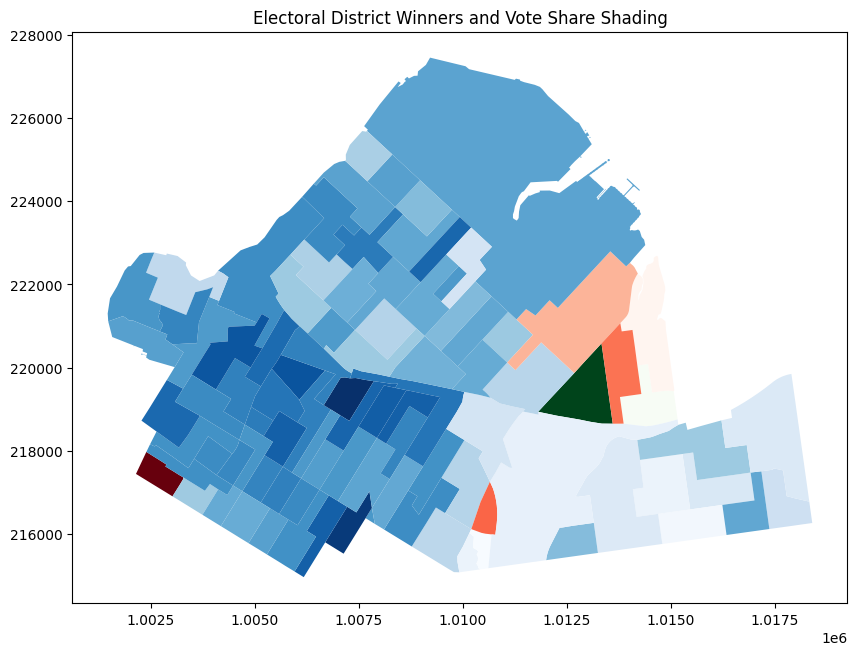

In [9]:
winners = gpd.GeoDataFrame(winners,geometry=winners['geometry'].apply(wkt.loads))

fig, ax = plt.subplots(1, figsize=(10, 10))
winners.plot(color=winners['color'], ax=ax)
ax.set_title("Electoral District Winners and Vote Share Shading")
plt.show()

In [15]:
d22.groupby('district_22_choice_1')['district_22_choice_2'].value_counts(dropna=False).unstack().fillna(0)

district_22_choice_2,Catherina Gioino,Evie Hantzopoulos,John J. Ciafone,Leonardo T. Bullaro,Nick Velkov,Tiffany Caban,Write-in,overvote,NaN
district_22_choice_1,,,,,,,,,
Catherina Gioino,3.0,108.0,96.0,75.0,51.0,256.0,0.0,3.0,200.0
Evie Hantzopoulos,363.0,20.0,311.0,502.0,176.0,1936.0,4.0,2.0,852.0
John J. Ciafone,173.0,359.0,19.0,251.0,67.0,175.0,4.0,1.0,559.0
Leonardo T. Bullaro,117.0,292.0,213.0,7.0,41.0,232.0,0.0,0.0,312.0
Nick Velkov,77.0,92.0,40.0,21.0,5.0,106.0,0.0,1.0,118.0
Tiffany Caban,739.0,3889.0,451.0,463.0,266.0,34.0,15.0,3.0,2062.0
Write-in,1.0,2.0,5.0,3.0,0.0,2.0,0.0,0.0,17.0
overvote,4.0,5.0,1.0,2.0,2.0,1.0,0.0,2.0,15.0


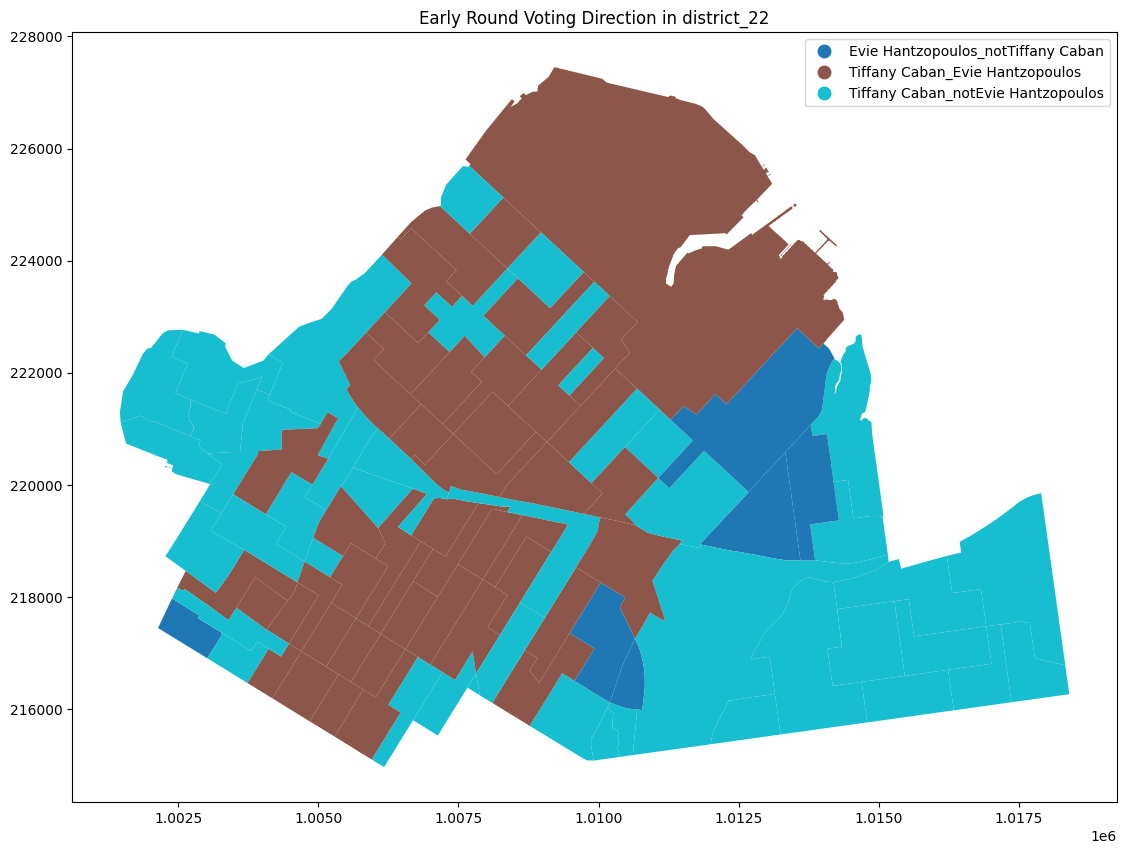

In [23]:
map_round_votes(d22,ed_gdf,'district_22','Tiffany Caban','Evie Hantzopoulos')

Clustering

In [29]:
p_cols = [col for col in occ_df.columns if col[-1] == 'p']
wp_cols = [col for col in occ_df.columns if col.startswith("w2") and col.endswith("p")]
wp_cols.remove('w2cop')
to_remove = [ 'w2psp',
 'w2sep',
 'w2npp',
 'w2govp',
 'w2nip']
wp_cols = [col for col in wp_cols if col not in to_remove]
demo_cols = ['nhw21p','nhb21p','h21p','nha21p','cvap21bapp','mhhi21']
cluster_cols = wp_cols + demo_cols

In [27]:
demo_occ = winner_twenty_two[['ed_name','nhw21p','nhb21p','h21p','nha21p','cvap21bapp','mhhi21']].merge(occ_df, left_on='ed_name', right_on='ElectDist', how='left')

In [30]:
df_cluster = demo_occ[cluster_cols]

In [31]:
scaler = StandardScaler()
df_cluster_scaled = scaler.fit_transform(df_cluster)

c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

Text(0.5, 1.0, 'Elbow Method')

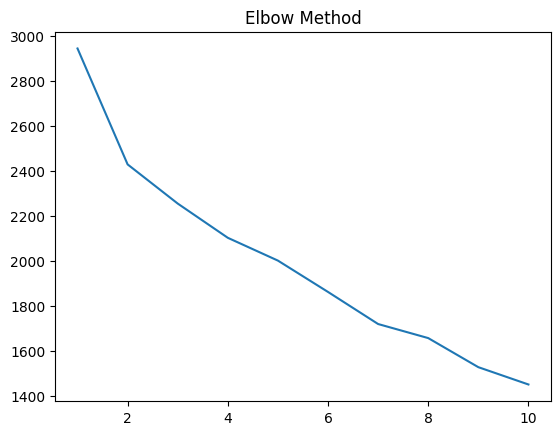

In [32]:
# elbow method to determine number of clusters
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(df_cluster_scaled)
    inertia.append(kmeans.inertia_)
plt.plot(range(1, 11), inertia)
plt.title('Elbow Method')

In [47]:
kmeans = KMeans(n_clusters=6, random_state=0)
kmeans.fit(df_cluster_scaled)
demo_occ['cluster'] = kmeans.labels_

c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [48]:
demo_occ_map = gpd.GeoDataFrame(demo_occ,geometry=demo_occ['geometry'].apply(wkt.loads))

In [50]:
demo_occ.groupby('cluster')[demo_cols].mean()

,nhw21p,nhb21p,h21p,nha21p,cvap21bapp,mhhi21
cluster,,,,,,
0,36.275808,13.302501,36.355494,10.606486,34.175813,28569.523077
1,52.604949,2.151463,28.088716,12.321795,51.437991,47274.663749
2,20.137328,4.907889,45.447851,27.168413,27.063907,36626.258297
3,55.478232,2.117658,20.693418,16.250840,56.602829,37709.978242
4,64.318982,1.906693,19.989711,9.931916,58.833390,54246.744751
5,68.489616,5.692802,17.643109,6.447367,43.499179,22661.655707


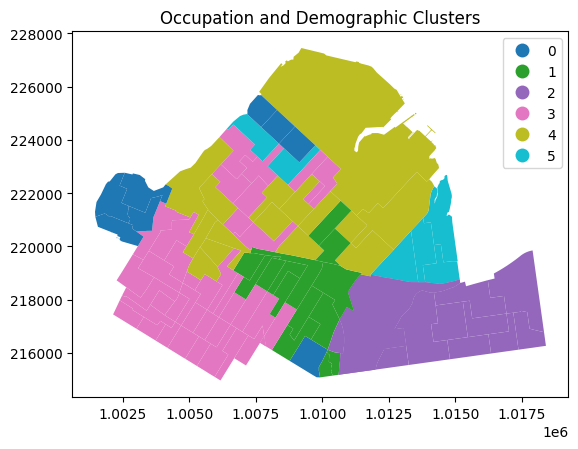

In [49]:
demo_occ_map['cluster'] = demo_occ_map['cluster'].astype('category')
demo_occ_map.plot(column='cluster',legend=True)
plt.title("Occupation and Demographic Clusters")
plt.show()

In [104]:
do_vote = demo_occ.merge(tc_full[['ed_name','vote_share']], on='ed_name', how='left')

In [106]:
for col in do_vote.columns:
    print(col)

ed_name
nhw21p
nhb21p
h21p
nha21p
cvap21bapp
mhhi21
ElectDist
Shape_Leng
Shape_Area
geometry
w2
wm2
wm2mgt
w2mgt
wm2bizfin
w2ban
wm2cm
w2cm
wm2ae
w2ae
wm2lps
w2sci
wm2coss
w2coss
wm2legal
w2law
wm2educ
w2edu
wm2adesm
w2adm
wm2doc
w2doc
wm2ht
w2ht
wm2hs
w2hs
wm2ff
w2ff
wm2food
w2food
wm2bgcm
w2bg
wm2pcare
w2pserve
wm2sales
w2sale
wm2office
w2oad
wm2farm
w2farm
wm2cons
w2cons
wm2imr
w2emr
wm2prod
w2prod
wm2trans
w2trans
wm2mat
w2mat
wf2
wf2mgt
wf2bizfin
wf2cm
wf2ae
wf2lps
wf2coss
wf2legal
wf2educ
wf2adesm
wf2hpto
wf2doc
wf2ht
wf2hs
wf2ff
wf2food
wf2bgcm
wf2pcare
wf2sales
wf2office
wf2farm
wf2cons
wf2imr
wf2prod
wf2trans
wf2mat
wm2ag
wm2min
wm2con
wm2mfg
wm2whole
wm2retail
wm2tw
wm2util
wm2info
wm2fin
wm2re
wm2profsci
wm2cmgt
wm2admin
wm2ed
wm2hcss
wm2arts
wm2acfood
wm2osvc
wm2pubad
wf2ag
wf2min
wf2con
wf2mfg
wf2whole
wf2retail
wf2tw
wf2util
wf2info
wf2fin
wf2re
wf2profsci
wf2cmgt
wf2admin
wf2ed
wf2hcss
wf2arts
wf2acfppd
wf2osvc
wf2pubad
w2mgr
w2service
w2sales
w2conmaint
w2prodtran
wps2


In [107]:
wp_cols

['w2mgtp',
 'w2banp',
 'w2cmp',
 'w2aep',
 'w2scip',
 'w2cossp',
 'w2lawp',
 'w2edup',
 'w2admp',
 'w2docp',
 'w2htp',
 'w2hsp',
 'w2ffp',
 'w2copp',
 'w2foodp',
 'w2bgp',
 'w2pservep',
 'w2salep',
 'w2oadp',
 'w2farmp',
 'w2conp',
 'w2emrp',
 'w2prodp',
 'w2tranp',
 'w2matp']

In [152]:
cor_matrix = do_vote[['tc_vote_share','cvap21bapp'] + wp_cols].corr()
cor_matrix

,tc_vote_share,cvap21bapp,w2mgtp,w2banp,w2cmp,w2aep,w2scip,w2cossp,w2lawp,w2edup,...,w2bgp,w2pservep,w2salep,w2oadp,w2farmp,w2conp,w2emrp,w2prodp,w2tranp,w2matp
tc_vote_share,1.000000,0.555115,0.287013,0.119128,0.348744,0.162890,0.169189,-0.171301,-0.261252,-0.136455,...,-0.130994,0.119625,-0.244472,-0.064874,0.148427,-0.513306,-0.063095,-0.083631,-0.219271,-0.040687
cvap21bapp,0.555115,1.000000,0.542852,0.498566,0.495882,0.026055,0.256593,-0.055916,0.092816,0.130671,...,-0.449792,0.120102,-0.407583,-0.220722,0.064999,-0.669300,-0.262765,-0.240676,-0.570318,-0.346158
w2mgtp,0.287013,0.542852,1.000000,0.520800,0.347431,0.039261,0.259032,0.052086,0.139220,0.034420,...,-0.164128,0.018381,-0.118067,-0.315459,0.047561,-0.358112,-0.139777,-0.219025,-0.284404,-0.329564
w2banp,0.119128,0.498566,0.520800,1.000000,0.331315,-0.025308,0.299076,-0.017990,0.239149,0.106067,...,-0.376240,0.067739,-0.216880,-0.201345,-0.028813,-0.243032,-0.313937,-0.012172,-0.399962,-0.224213
w2cmp,0.348744,0.495882,0.347431,0.331315,1.000000,0.171431,0.178868,-0.082016,0.024703,0.168037,...,-0.089229,0.041296,-0.315319,0.164363,0.066993,-0.308047,0.038161,0.025042,-0.280539,-0.332084
w2aep,0.162890,0.026055,0.039261,-0.025308,0.171431,1.000000,-0.065939,0.106327,-0.013131,-0.086091,...,0.229221,0.146752,-0.127843,0.051668,0.013021,-0.212497,0.186333,0.464569,0.074990,0.060132
w2scip,0.169189,0.256593,0.259032,0.299076,0.178868,-0.065939,1.000000,0.024230,0.117417,0.136610,...,-0.107120,-0.133118,-0.105338,-0.342543,-0.066366,-0.111388,-0.294307,0.027815,-0.180780,-0.106490
w2cossp,-0.171301,-0.055916,0.052086,-0.017990,-0.082016,0.106327,0.024230,1.000000,0.224216,0.323656,...,0.212449,-0.032331,0.344397,-0.201988,0.184850,0.103770,0.027692,-0.002248,0.299252,-0.028359
w2lawp,-0.261252,0.092816,0.139220,0.239149,0.024703,-0.013131,0.117417,0.224216,1.000000,0.310693,...,0.098902,-0.205739,0.109561,-0.008888,-0.080214,-0.123832,0.130356,0.025542,-0.156741,-0.110370
w2edup,-0.136455,0.130671,0.034420,0.106067,0.168037,-0.086091,0.136610,0.323656,0.310693,1.000000,...,-0.035586,-0.107929,-0.009881,0.287293,0.006544,0.119080,-0.113900,-0.166539,0.069513,-0.063828


In [115]:
do_vote['log_mhhi21'] = np.log(do_vote['mhhi21'])

In [123]:
target = do_vote['vote_share']
mod1 = sm.OLS(target, sm.add_constant(do_vote[['log_mhhi21']])).fit()
mod2 = sm.OLS(target, sm.add_constant(do_vote[['log_mhhi21','nhw21p']])).fit()
mod3 = sm.OLS(target, sm.add_constant(do_vote[['log_mhhi21','nhw21p','cvap21bapp']])).fit()
mod4 = sm.OLS(target, sm.add_constant(do_vote[['log_mhhi21','nhw21p','cvap21bapp','w2admp']])).fit()
mod5 = sm.OLS(target, sm.add_constant(do_vote[['log_mhhi21','nhw21p','cvap21bapp','w2admp','w2cmp']])).fit()

In [124]:
summary_col([mod1,mod2,mod3,mod4,mod5], stars=True)

,vote_share I,vote_share II,vote_share III,vote_share IIII,vote_share IIIII
const,7.9113,3.7077,11.3425,15.8870,14.3473
,(17.6109),(17.5375),(14.7398),(14.2804),(14.7934)
log_mhhi21,3.5679**,3.3458**,1.2045,1.0945,1.2245
,(1.6845),(1.6675),(1.4372),(1.3842),(1.4236)
nhw21p,,0.1274*,-0.1947**,-0.1568**,-0.1523**
,,(0.0691),(0.0771),(0.0754),(0.0764)
cvap21bapp,,,0.6271***,0.3727***,0.3550**
,,,(0.0990),(0.1304),(0.1374)
w2admp,,,,0.9901***,0.9665***
,,,,(0.3465),(0.3525)


In [144]:
colnames = ['a', 'b', 'c', 'd', 'e', 'f',
       'g', 'h', 'i', 'j',
       'k', 
        'AD', 'ED', 'County', 'EDAD Status', 'Event', 'Party/Independent Body',
       'Office/Position Title', 'District Key', 'VoteFor', 'Unit Name',
       'Tally']

good_cols = ['AD', 'ED', 'County', 'EDAD Status', 'Event', 'Party/Independent Body',
       'Office/Position Title', 'District Key', 'VoteFor', 'Unit Name',
       'Tally']

def read_noncc_votes(filepath,colnames,good_cols):
    df = pd.read_csv(filepath,header=None, names=colnames)
    df = df[good_cols]
    df['precinct'] = 'AD: ' + df['AD'].astype(str) + ' ' + 'ED: ' + df['ED'].astype(str).str.zfill(3)
    df['ed_name'] = df['AD'].astype(str) + df['ED'].astype(str).str.zfill(3)
    return df
def make_vote_share(df,candidates):
    df_cand = df[df['Unit Name'].isin(candidates)]
    df_cand = df_cand[['precinct','ed_name','Unit Name','Tally']]
    df_cand.columns = ['precinct','ed_name','candidate','votes']
    df_cand['ed_total'] = df_cand.groupby('ed_name')['votes'].transform('sum')
    df_cand['vote_share'] = round(df_cand['votes'] / df_cand['ed_total'] * 100,2)
    df_cand['vote_share'] = pd.to_numeric(df_cand['vote_share'], errors='coerce')
    df_cand.dropna(inplace=True)
    return df_cand

In [145]:
filepath = '../data/aoc_raw.csv'
candidates = ['Alexandria Ocasio-Cortez','Joseph Crowley']
noncc = read_noncc_votes(filepath,colnames,good_cols)
mvs = make_vote_share(noncc,candidates)

In [147]:
aoc_clean = mvs[mvs['candidate'] == 'Alexandria Ocasio-Cortez']

In [149]:
aoc_clean.columns = ['precinct','ed_name','candidate','aoc_votes','ed_total','aoc_vote_share']

In [150]:
do_vote.rename(columns={'vote_share':'tc_vote_share'},inplace=True)

In [154]:
aoc_clean['ed_name'] = aoc_clean['ed_name'].astype('Int64')

C:\Users\samtg\AppData\Local\Temp\ipykernel_13212\3275283636.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aoc_clean['ed_name'] = aoc_clean['ed_name'].astype('Int64')


In [155]:
do_vote = do_vote.merge(aoc_clean[['ed_name','aoc_vote_share']], on='ed_name', how='left')

In [157]:
do_vote['aoc_vote_share_standardized'] = (do_vote['aoc_vote_share'] - do_vote['aoc_vote_share'].mean()) / do_vote['aoc_vote_share'].std()
do_vote['tc_vote_share_standardized'] = (do_vote['tc_vote_share'] - do_vote['tc_vote_share'].mean()) / do_vote['tc_vote_share'].std()
do_vote['vote_diff'] = do_vote['aoc_vote_share_standardized'] - do_vote['tc_vote_share_standardized']

In [159]:
do_vote.dropna(subset=['vote_diff'],inplace=True)

In [161]:
do_vote_map = gpd.GeoDataFrame(do_vote,geometry=do_vote['geometry'].apply(wkt.loads))

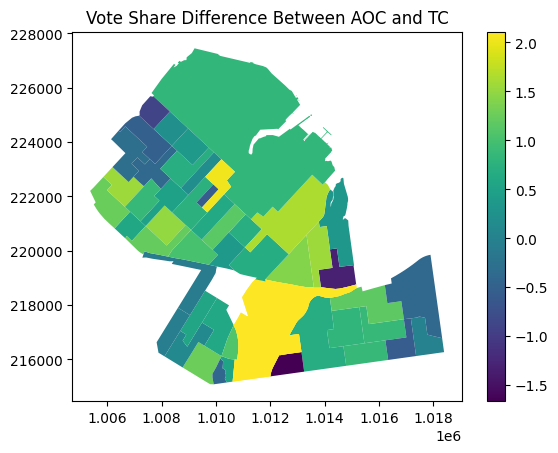

In [162]:
do_vote_map.plot(column='vote_diff',legend=True)
plt.title("Vote Share Difference Between AOC and TC")
plt.show()